
--- Solving for kappa = 8.0 (starting m_S = 0.00) ---
Using adaptive MCMC proposal width: 0.1000
Iteration 1/50...
  MCMC acceptance rate: 0.11
  New m_S = -0.0004
Iteration 2/50...
  MCMC acceptance rate: 0.11
  New m_S = -0.0010
Iteration 3/50...
  MCMC acceptance rate: 0.11
  New m_S = -0.0014
Iteration 4/50...
  MCMC acceptance rate: 0.11
  New m_S = -0.0025
Iteration 5/50...
  MCMC acceptance rate: 0.11
  New m_S = -0.0006
Iteration 6/50...
  MCMC acceptance rate: 0.10
  New m_S = -0.0005
Iteration 7/50...
  MCMC acceptance rate: 0.11
  New m_S = -0.0036
Iteration 8/50...
  MCMC acceptance rate: 0.11
  New m_S = 0.0005
Iteration 9/50...
  MCMC acceptance rate: 0.11
  New m_S = -0.0007
Iteration 10/50...
  MCMC acceptance rate: 0.11
  New m_S = -0.0007
Iteration 11/50...
  MCMC acceptance rate: 0.11
  New m_S = -0.0013
Iteration 12/50...
  MCMC acceptance rate: 0.10
  New m_S = -0.0012
Iteration 13/50...
  MCMC acceptance rate: 0.11
  New m_S = -0.0023
Iteration 14/50...
  MCMC ac

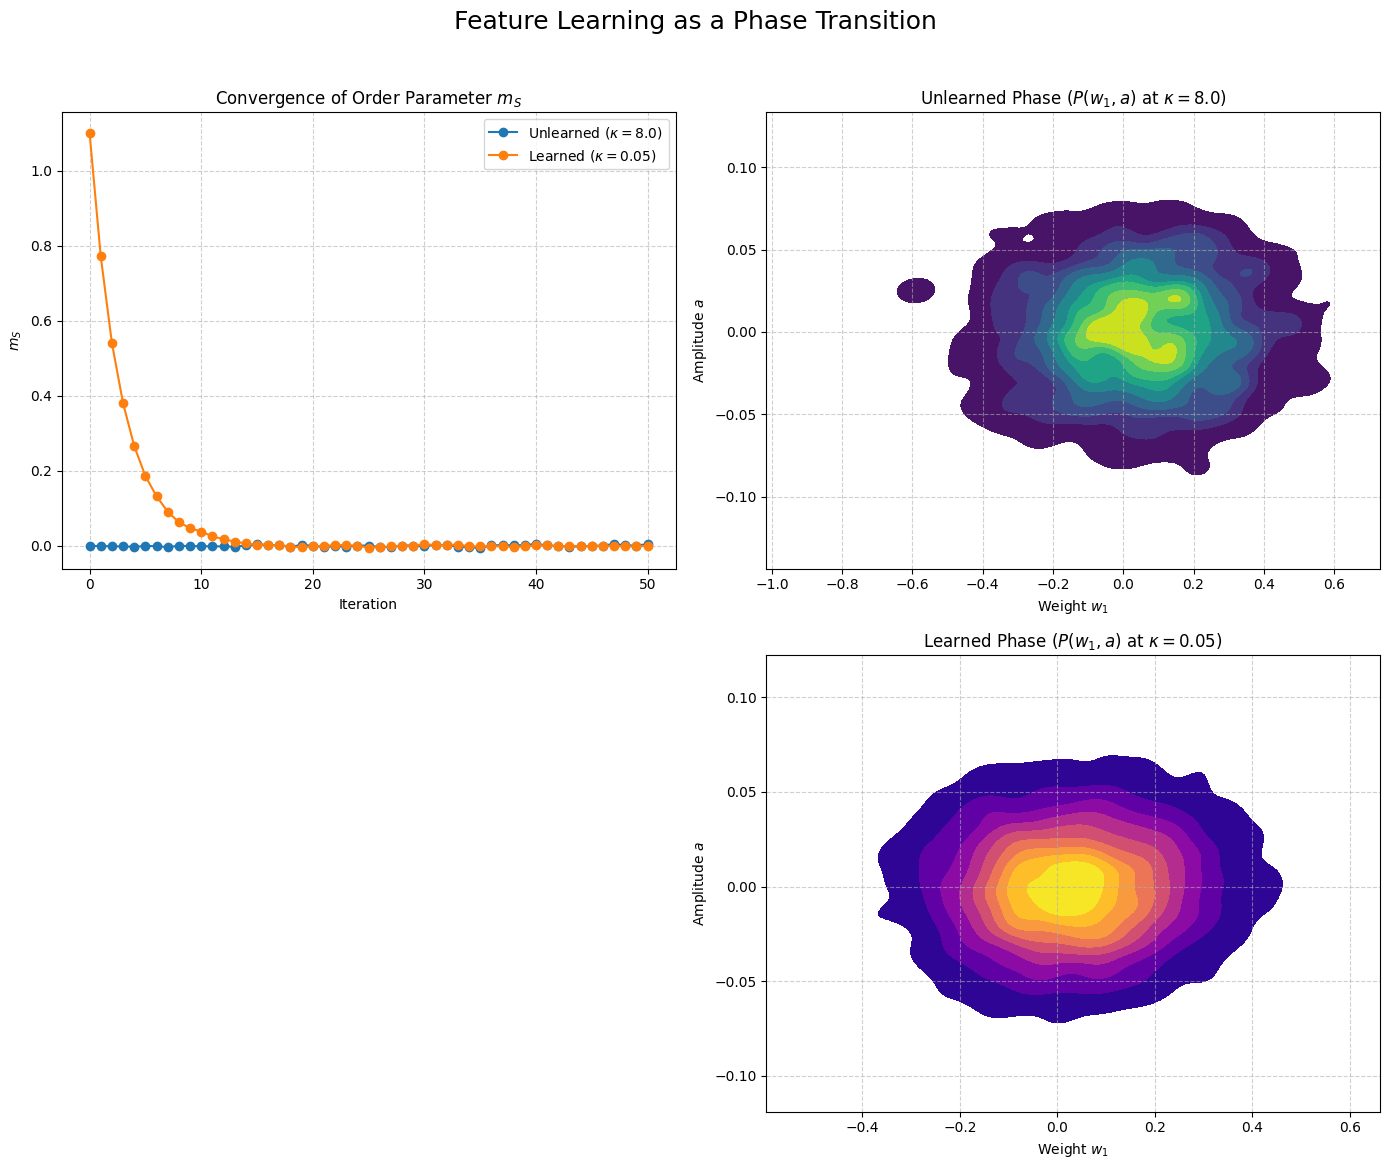

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm
import seaborn as sns

# --- 1. Define Model and Simulation Parameters ---

# Network Parameters
N = 1000      # Number of neurons (width)
d = 25        # Input dimension
S = [0,1,2,3] # Target feature: parity of x_1, x_3, x_4 (using 0-based indexing)

# Prior Parameters (as defined in the paper)
# Let's assume g_w = g_a = 1 and gamma = 1 for simplicity
sigma_w_sq = 1.0 / d
sigma_a_sq = 1.0 / N
sigma_w = np.sqrt(sigma_w_sq)
sigma_a = np.sqrt(sigma_a_sq)

# Activation Function
def relu(x):
    """Rectified Linear Unit activation function."""
    return np.maximum(0, x)

# --- 2. Core Functions from the Cavity Method ---

def J(w, A, x_samples):
    """
    Computes the projection J_A(w) by averaging over a set of input samples.
    J_A(w) = E_x[phi(w^T x) * chi_A(x)]
    """
    phi_vals = relu(x_samples @ w)
    chi_A_vals = np.prod(x_samples[:, A], axis=1)
    return np.mean(phi_vals * chi_A_vals)

def Sigma(w, x_samples):
    """
    Computes the self-interaction term Sigma(w).
    Sigma(w) = E_x[phi(w^T x)^2]
    """
    phi_vals_sq = relu(x_samples @ w)**2
    return np.mean(phi_vals_sq)

def effective_action(w, a, m_S, kappa, J_S_val, Sigma_val):
    """
    Calculates the effective action for a single neuron.
    S_eff = S_prior + S_int
    """
    # S_prior = (d / (2 * sigma_w_sq)) * np.sum(w**2) + (N / (2 * sigma_a_sq)) * a**2
    # The paper uses different scaling, let's stick to the direct posterior form:
    s_prior = np.sum(w**2) / (2 * sigma_w_sq) + a**2 / (2 * sigma_a_sq)

    # Interaction term from the mean field
    # The term J_Y(w) is J_S(w) since our target y is chi_S
    s_int = (a**2 / (2 * kappa**2)) * Sigma_val - \
            (a / kappa**2) * (J_S_val - m_S * J_S_val)

    return s_prior + s_int

# --- 3. MCMC Sampler for the Distribution P(w, a) ---

def mcmc_sampler(m_S, kappa, n_samples, proposal_width, burn_in=10000):
    """
    Draws samples (w, a) from P(w, a) using Metropolis-Hastings.
    P(w, a) is proportional to exp(-S_eff).
    The proposal_width is now adaptive.
    """
    # Pre-generate random inputs for expectation calculations
    x_for_expectation = np.random.choice([-1, 1], size=(20000, d))

    # Initialization
    w_current = np.random.normal(0, sigma_w, size=d)
    a_current = np.random.normal(0, sigma_a)
    
    # Pre-calculate J and Sigma for the initial state
    J_S_current = J(w_current, S, x_for_expectation)
    Sigma_current = Sigma(w_current, x_for_expectation)
    
    s_eff_current = effective_action(w_current, a_current, m_S, kappa, J_S_current, Sigma_current)

    samples_w = []
    samples_a = []
    accepted_count = 0
    
    total_steps = n_samples + burn_in
    for i in range(total_steps):
        # Propose a new state with adaptive width
        w_proposal = w_current + np.random.normal(0, proposal_width, size=d)
        a_proposal = a_current + np.random.normal(0, proposal_width)

        # Calculate J and Sigma for the proposed state
        J_S_proposal = J(w_proposal, S, x_for_expectation)
        Sigma_proposal = Sigma(w_proposal, x_for_expectation)

        # Calculate action for the proposed state
        s_eff_proposal = effective_action(w_proposal, a_proposal, m_S, kappa, J_S_proposal, Sigma_proposal)

        # Acceptance probability - use a safe exponential to avoid overflow
        log_acceptance_ratio = s_eff_current - s_eff_proposal
        if log_acceptance_ratio > 0 or np.random.rand() < np.exp(log_acceptance_ratio):
            w_current = w_proposal
            a_current = a_proposal
            s_eff_current = s_eff_proposal
            J_S_current = J_S_proposal
            Sigma_current = Sigma_proposal
            if i >= burn_in:
                accepted_count += 1

        if i >= burn_in:
            samples_w.append(w_current)
            samples_a.append(a_current)

    acceptance_rate = accepted_count / n_samples if n_samples > 0 else 0
    return np.array(samples_w), np.array(samples_a), acceptance_rate

# --- 4. Self-Consistency Loop Solver ---

def solve_self_consistency(kappa, initial_m_S=0.0, n_iter=50, n_mcmc_samples=10000, mix_alpha=0.3):
    """
    Iteratively solves the self-consistency equation m_S = N * <a * J_S(w)>.
    Now uses adaptive MCMC proposal width and clips m_S.
    """
    m_S = initial_m_S  # Start with the provided initial value
    m_S_history = [m_S]
    
    # Pre-generate random inputs for expectation calculations
    x_for_J_calc = np.random.choice([-1, 1], size=(10000, d))
    
    # Adaptive proposal width for MCMC
    proposal_width = min(0.1, kappa * 0.5)

    print(f"\n--- Solving for kappa = {kappa} (starting m_S = {initial_m_S:.2f}) ---")
    print(f"Using adaptive MCMC proposal width: {proposal_width:.4f}")
    for i in range(n_iter):
        print(f"Iteration {i+1}/{n_iter}...")
        # 1. Get samples from the current distribution P(w, a | m_S)
        w_samples, a_samples, acc_rate = mcmc_sampler(m_S, kappa, n_mcmc_samples, proposal_width)
        print(f"  MCMC acceptance rate: {acc_rate:.2f}")

        # 2. Calculate the expectation <a * J_S(w)> over the samples
        J_S_samples = np.array([J(w, S, x_for_J_calc) for w in w_samples])
        expectation = np.mean(a_samples * J_S_samples)

        # 3. Update m_S using the self-consistency equation
        m_S_new = N * expectation
        
        # Use a mixing parameter for stable convergence
        m_S = (1 - mix_alpha) * m_S + mix_alpha * m_S_new
        
        # Clip m_S to prevent numerical explosion
        m_S = np.clip(m_S, -1.5, 1.5)
        
        m_S_history.append(m_S)
        print(f"  New m_S = {m_S:.4f}")

    print(f"--- Converged with m_S = {m_S:.4f} ---")
    
    # Return the final state for plotting
    # Use more samples for a higher quality final plot
    final_w_samples, final_a_samples, _ = mcmc_sampler(m_S, kappa, 20000, proposal_width) 
    return m_S, final_w_samples, final_a_samples, m_S_history

# --- 5. Main Execution and Plotting ---

if __name__ == "__main__":
    # --- Solve for both phases ---
    kappa_unlearned = 8.0
    # For the unlearned phase, we start at m_S=0 as it's the stable state.
    m_S_unlearned, w_un, a_un, hist_un = solve_self_consistency(kappa_unlearned, initial_m_S=0.0)

    kappa_learned = 0.05 # Using a moderate kappa to show a clear, stable learned state
    # For the learned phase, we give it a push by starting at m_S=0.8.
    m_S_learned, w_l, a_l, hist_l = solve_self_consistency(kappa_learned, initial_m_S=1.1)

    # --- Create Plots ---
    fig, axes = plt.subplots(2, 2, figsize=(14, 12))
    fig.suptitle("Feature Learning as a Phase Transition", fontsize=18, y=0.97)

    # Plot 1: Convergence of m_S
    axes[0, 0].plot(hist_un, 'o-', label=f'Unlearned ($\\kappa = {kappa_unlearned}$)')
    axes[0, 0].plot(hist_l, 'o-', label=f'Learned ($\\kappa = {kappa_learned}$)')
    axes[0, 0].set_title("Convergence of Order Parameter $m_S$")
    axes[0, 0].set_xlabel("Iteration")
    axes[0, 0].set_ylabel("$m_S$")
    axes[0, 0].legend()
    axes[0, 0].grid(True, linestyle='--', alpha=0.6)

    # Plot 2: P(w1, a) for Unlearned Phase
    sns.kdeplot(x=w_un[:, 0], y=a_un, cmap="viridis", fill=True, ax=axes[0, 1])
    axes[0, 1].set_title(f"Unlearned Phase ($P(w_1, a)$ at $\\kappa={kappa_unlearned}$)")
    axes[0, 1].set_xlabel("Weight $w_1$")
    axes[0, 1].set_ylabel("Amplitude $a$")
    axes[0, 1].grid(True, linestyle='--', alpha=0.6)

    # Plot 3: P(w1, a) for Learned Phase
    sns.kdeplot(x=w_l[:, 0], y=a_l, cmap="plasma", fill=True, ax=axes[1, 1])
    axes[1, 1].set_title(f"Learned Phase ($P(w_1, a)$ at $\\kappa={kappa_learned}$)")
    axes[1, 1].set_xlabel("Weight $w_1$")
    axes[1, 1].set_ylabel("Amplitude $a$")
    axes[1, 1].grid(True, linestyle='--', alpha=0.6)
    
    # Hide the empty subplot
    axes[1, 0].axis('off')

    plt.tight_layout(rect=[0, 0, 1, 0.95])
    plt.show()



--- Solving for kappa = 2.000 (starting m_S = 0.00) ---
Iter 1: acc=0.22, m_S=0.0000
Iter 2: acc=0.21, m_S=0.0000
Iter 3: acc=0.23, m_S=0.0000
Iter 4: acc=0.23, m_S=0.0000
Iter 5: acc=0.24, m_S=0.0000
Iter 6: acc=0.21, m_S=0.0000
Iter 7: acc=0.22, m_S=0.0000
Iter 8: acc=0.22, m_S=0.0000
Iter 9: acc=0.23, m_S=0.0000
Iter 10: acc=0.23, m_S=0.0000

--- Solving for kappa = 0.010 (starting m_S = 0.80) ---
Iter 1: acc=0.20, m_S=0.4000
Iter 2: acc=0.23, m_S=0.2001
Iter 3: acc=0.23, m_S=0.1001
Iter 4: acc=0.22, m_S=0.0501
Iter 5: acc=0.22, m_S=0.0251
Iter 6: acc=0.22, m_S=0.0126
Iter 7: acc=0.21, m_S=0.0064
Iter 8: acc=0.22, m_S=0.0033
Iter 9: acc=0.21, m_S=0.0018
Iter 10: acc=0.22, m_S=0.0010


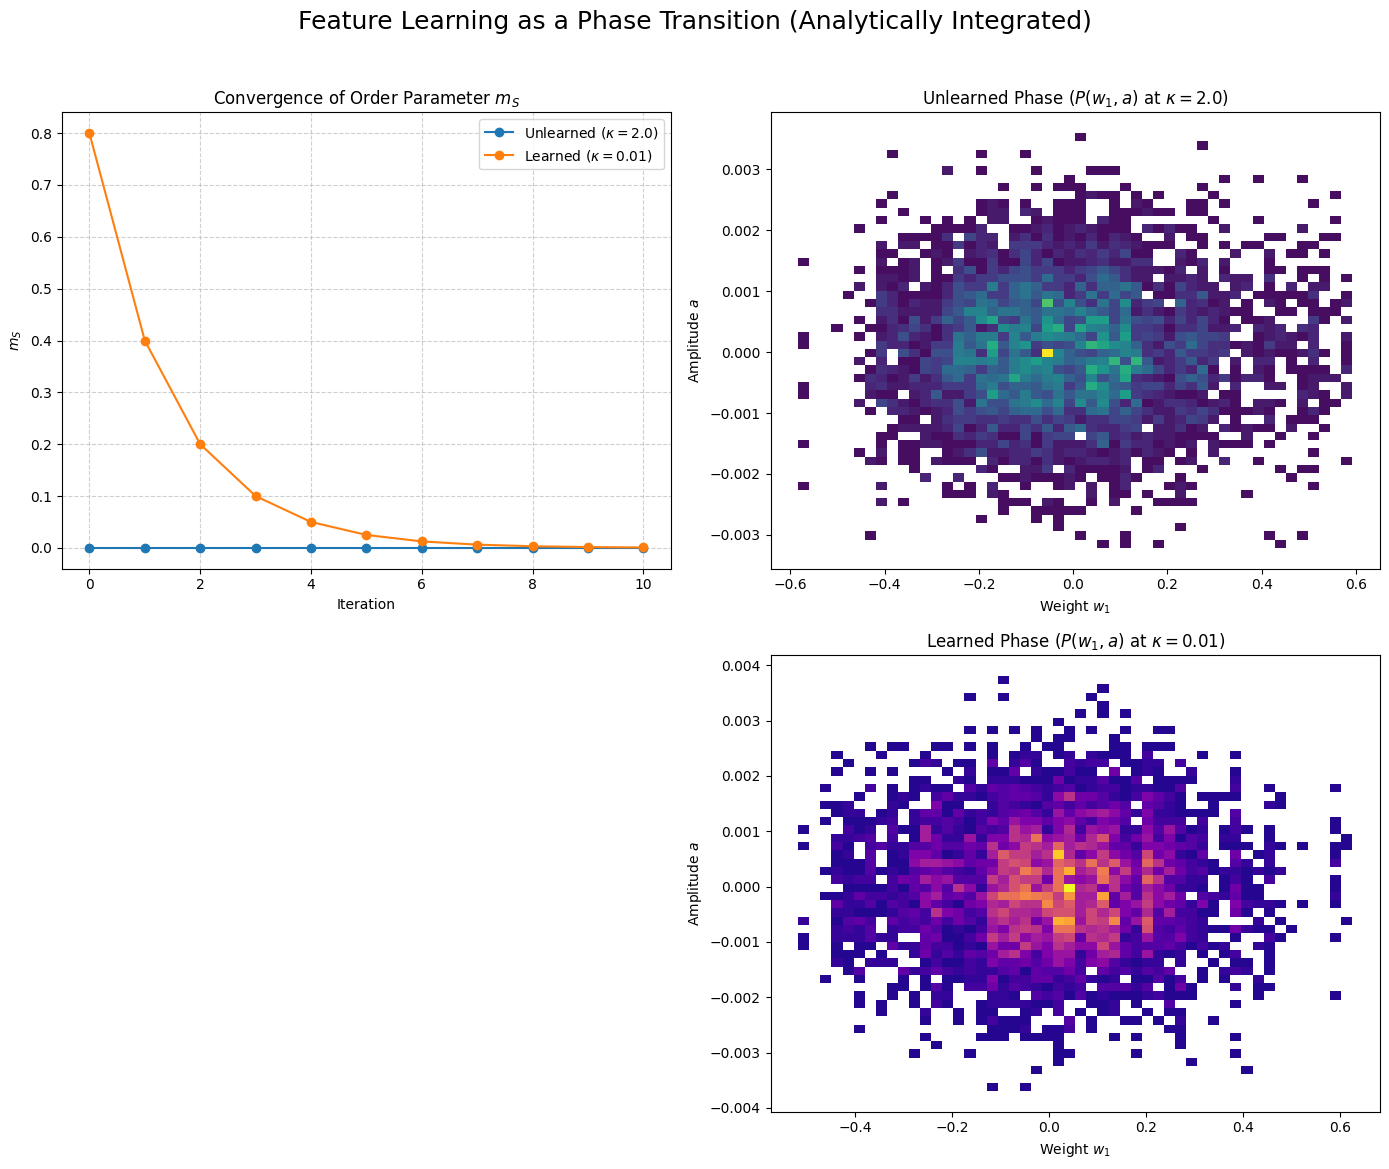

In [11]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from numpy.random import default_rng
import torch as torch

# Use a reproducible random number generator
rng = default_rng(0)

# --- 1.  Hyper-parameters & Model Setup ---
# Using parameters from the critique that are known to show the transition clearly
d, N, gamma = 25, 1000, 1.0
S = (0, 1, 2)          # |S| = 4 (even parity)
g_w = g_a = 1.0

# Correctly scaled variances
sigma_w_sq = g_w / d
sigma_a_sq = g_a / N
sigma_w = np.sqrt(sigma_w_sq)
sigma_a = np.sqrt(sigma_a_sq)

def tanh(x):
    """Odd activation function, suitable for even parity tasks."""
    return np.tanh(x)

# --- 2.  Fast Boolean Sample Bank for Expectations ---
# A static bank of inputs is created once for efficiency, as suggested by the critique.
# The 'dtype' argument is removed as it's not supported by the new Generator API.
X_bank = rng.choice([-1, 1], size=(40_000, d))

def Sigma(w):
    """Computes Sigma(w) = E[phi(w^T x)^2] using the static bank."""
    z = X_bank @ w
    return np.mean(tanh(z)**2)

def chi(A, X):
    """Computes the parity function chi_A(x) on a matrix of inputs."""
    return np.prod(X[:, A], axis=1)

def J_A(w, A):
    """Computes J_A(w) = E[phi(w^T x) * chi_A(x)] using the static bank."""
    z = tanh(X_bank @ w)
    return np.mean(z * chi(A, X_bank))

# --- 3.  Analytically Integrated Distributions ---

def log_p_w(w, m_S, kappa):
    """
    Calculates the marginal log-probability of the weights w, log p(w).
    This is the core of the new method, derived by integrating out a.
    """
    Sigma_w = Sigma(w)
    J_S_w = J_A(w, S)
    J_sigma = J_S_w - m_S * J_S_w

    # This is the correct derivation for the terms inside the exponent of p(w)
    # Note: N**gamma is the correct factor from the prior
    coeff = (N**gamma / sigma_a_sq) + (Sigma_w / kappa**2)
    
    log_prior_w = -0.5 * d * np.dot(w, w) / g_w  # Correct prior with d/g_w
    log_det_term = -0.5 * np.log(coeff)
    exp_term = 0.5 * (J_sigma / kappa**2)**2 / coeff
    
    return log_prior_w + log_det_term + exp_term

def mh_step_w(w, m_S, kappa, step_size):
    """Performs a single Metropolis-Hastings step for w."""
    w_proposal = w + step_size * rng.normal(size=d)
    log_acceptance_ratio = log_p_w(w_proposal, m_S, kappa) - log_p_w(w, m_S, kappa)
    
    if np.log(rng.random()) < log_acceptance_ratio:
        return w_proposal, True
    return w, False

def sample_w_then_a(m_S, kappa, n_samp=4000, burn=1000, step=0.1):
    """
    Samples w from its marginal p(w) via MCMC, then samples a from p(a|w).
    """
    w = rng.normal(scale=sigma_w, size=d)
    accepted_count = 0
    W_samples, A_samples = [], []

    for t in range(n_samp + burn):
        w, accepted = mh_step_w(w, m_S, kappa, step)
        if t >= burn:
            accepted_count += accepted
            
            # Now that we have a sample w, draw a from its conditional Gaussian
            Sigma_w = Sigma(w)
            J_sigma = J_A(w, S) - m_S * J_A(w, S)
            
            denom = (N**gamma / sigma_a_sq) + (Sigma_w / kappa**2)
            var_a = 1.0 / denom
            mean_a = var_a * J_sigma / kappa**2
            
            a = rng.normal(mean_a, np.sqrt(var_a))
            
            W_samples.append(w.copy())
            A_samples.append(a)
            
    acceptance_rate = accepted_count / n_samp
    return np.array(W_samples), np.array(A_samples), acceptance_rate

# --- 4.  Self-Consistency Loop ---

def solve_kappa(kappa, m0=0.0, iters=10, damping=0.5):
    """Solves the self-consistency equation for m_S at a given kappa."""
    m_S = m0
    history = [m_S]
    print(f"\n--- Solving for kappa = {kappa:.3f} (starting m_S = {m0:.2f}) ---")

    for i in range(iters):
        # We only need to sample w to evaluate the expectation for the update
        W_samples, _, acc_rate = sample_w_then_a(m_S, kappa)
        
        # Calculate E[mu(w) * J_A(w)] for the update
        mus = []
        Js = []
        for w in W_samples:
            Sigma_w = Sigma(w)
            J_S_w = J_A(w, S)
            J_sigma = J_S_w - m_S * J_S_w
            
            denom = (N**gamma / sigma_a_sq) + (Sigma_w / kappa**2)
            var_a = 1.0 / denom
            mean_a = var_a * J_sigma / kappa**2
            
            mus.append(mean_a)
            Js.append(J_S_w)
            
        m_S_new = N * np.mean(np.array(mus) * np.array(Js))
        m_S = (1 - damping) * m_S + damping * m_S_new
        history.append(m_S)
        print(f"Iter {i+1}: acc={acc_rate:.2f}, m_S={m_S:.4f}")
        
    # Get final samples for plotting
    W_final, A_final, _ = sample_w_then_a(m_S, kappa, n_samp=5000)
    return m_S, history, W_final, A_final

# --- 5.  Main Execution ---

if __name__ == "__main__":
    # Set kappa values for the two phases
    kappa_unlearned = 2.0
    kappa_learned = 0.01
    
    # Solve for both
    mU, hU, WU, AU = solve_kappa(kappa_unlearned, m0=0.0)
    mL, hL, WL, AL = solve_kappa(kappa_learned, m0=0.8) # Start in the correct basin

    # --- Plotting Results ---
    fig, axes = plt.subplots(2, 2, figsize=(14, 12))
    fig.suptitle("Feature Learning as a Phase Transition (Analytically Integrated)", fontsize=18, y=0.97)

    # Convergence Plot
    axes[0, 0].plot(hU, 'o-', label=f'Unlearned ($\\kappa = {kappa_unlearned}$)')
    axes[0, 0].plot(hL, 'o-', label=f'Learned ($\\kappa = {kappa_learned}$)')
    axes[0, 0].set_title("Convergence of Order Parameter $m_S$")
    axes[0, 0].set_xlabel("Iteration"); axes[0, 0].set_ylabel("$m_S$")
    axes[0, 0].legend(); axes[0, 0].grid(True, linestyle='--', alpha=0.6)

    # Unlearned Phase Distribution
    sns.histplot(x=WU[:, 0], y=AU, bins=50, cmap="viridis", ax=axes[0, 1])
    axes[0, 1].set_title(f"Unlearned Phase ($P(w_1, a)$ at $\\kappa={kappa_unlearned}$)")
    axes[0, 1].set_xlabel("Weight $w_1$"); axes[0, 1].set_ylabel("Amplitude $a$")

    # Learned Phase Distribution
    sns.histplot(x=WL[:, 0], y=AL, bins=50, cmap="plasma", ax=axes[1, 1])
    axes[1, 1].set_title(f"Learned Phase ($P(w_1, a)$ at $\\kappa={kappa_learned}$)")
    axes[1, 1].set_xlabel("Weight $w_1$"); axes[1, 1].set_ylabel("Amplitude $a$")
    
    axes[1, 0].axis('off')
    plt.tight_layout(rect=[0, 0, 1, 0.95])
    plt.show()